<h1><center> EDA (Análisis Exploratorio de Datos) y algo más... </center></h1>

In [118]:
# Data manipulation libraries
import numpy as np 
import pandas as pd 

# Data visualisation 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Web scraping 
from bs4 import BeautifulSoup, Comment
from requests import get
import warnings
warnings.filterwarnings("ignore")

Vamos a darle continuidad al ejercicio anterior. El problema con el conjunto de datos actual es que incluye Pokémon de menor evolución. Por ejemplo, Charmander, Charmeleon y Charizard están todos incluidos. 

Preferiría que sólo se incluyera el último Pokémon de la evolución porque el modo competitivo solo se realiza principalmente en función de esos. Tratemos de solucionar este problema a través del árbol de evolución de Pokémon del sitio web pokemondb. 

---

### Web scraping para mejorar nuestro conjunto de datos

**Paso 1: encontrar la URL**

El sitio web que elegí es el sitio web de pokemondb que enumera las evoluciones de todos los Pokémon en esta forma:

![img](https://i.postimg.cc/qR8yX0qW/Pika.png)


In [119]:
poke_url = 'https://pokemondb.net/evolution#evo-g2'
response = get(poke_url) 
html_soup = BeautifulSoup(response.text, 'html.parser')

In [120]:
html_soup

<!DOCTYPE html>

<html lang="en">
<head>
<meta charset="utf-8"/>
<title>Pokémon evolution charts | Pokémon Database</title>
<link href="https://img.pokemondb.net" rel="preconnect"/>
<style>@font-face{font-family:"Fira Sans";font-style:normal;font-weight:400;font-display:swap;src:url("/static/fonts/fira-sans-v10-latin-400.woff2") format("woff2");unicode-range:U+0000-00FF,U+0131,U+0152-0153,U+02BB-02BC,U+02C6,U+02DA,U+02DC,U+2000-206F,U+2074,U+20AC,U+2122,U+2191,U+2193,U+2212,U+2215,U+FEFF,U+FFFD}@font-face{font-family:"Fira Sans";font-style:italic;font-weight:400;font-display:swap;src:url("/static/fonts/fira-sans-v10-latin-400i.woff2") format("woff2");unicode-range:U+0000-00FF,U+0131,U+0152-0153,U+02BB-02BC,U+02C6,U+02DA,U+02DC,U+2000-206F,U+2074,U+20AC,U+2122,U+2191,U+2193,U+2212,U+2215,U+FEFF,U+FFFD}@font-face{font-family:"Fira Sans";font-style:normal;font-weight:700;font-display:swap;src:url("/static/fonts/fira-sans-v10-latin-600.woff2") format("woff2");unicode-range:U+0000-00FF,U+01

**Paso 2: examinar el HTML de la página y extraer los datos**

Ahora que tenemos el HTML, tenemos que examinar dónde se encuentra exactamente la información que queremos. Podemos utilizar las herramientas de desarrollo de Google Chrome para ver qué parte del árbol HTML nos interesa.

![img](https://i.postimg.cc/qRf8WwFf/Pika-HTML.png)



In [121]:
infocard = html_soup.find_all('div', {'class' : 'infocard-list-evo'})

**Paso 3: localizar y extraer toda la información útil en el HTML**

Ahora que hemos seleccionado todos los divs, necesitamos extraer la información que nos sea útil. Me gustaría obtener la siguiente información:

    La evolución es el pokemon (1º, 2º, etc.)
    El número de Pokémon (lo necesitaremos en el futuro para filtrar)
    El texto pequeño debajo del pokemon (nuevamente, esto se usará para filtrar)
    El nombre del pokemon

Toda la información que queremos se puede encontrar en el intervalo con la clase 'infocard-lg-data text-muted' como se puede ver en la captura de pantalla a continuación:

![img](https://i.postimg.cc/yxh1vgJp/Info-Pic.png)

Solo necesitamos extraer el número del pokemon, el nombre del pokemon y la etiqueta con la clase 'ent-name' que tiene el texto pequeño debajo del pokemon.

También utilizo enumerate para crear un índice de la evolución del pokemon. Entonces, por ejemplo, en los casos simples (Charmander -> Charmeleon -> Charizard) con enumerate logro darle a Charmander el número 1, Charmeleon el número 2 y Charizard el número 3.

Desafortunadamente, esto falla estrepitosamente para los casos complejos (como el de Pikachu) pero trataremos esto en un paso posterior.

In [122]:
raw = []
for chain in infocard:
    raw.append([(i, #indice
                  x.find('small').getText(), #numero del pokemon
                  x.find_all('small')[1].getText(), #tipos / otra caracteristica
                  x.find('a', {'class':'ent-name'}).getText()#nombre de pokemon
                 ) 
                 for i, x in enumerate(
                     list(chain.find_all('span', 
                                         {'class':'infocard-lg-data text-muted'})))])

raw[12:16] ## Our list contains touple lists with the evolution branch of each pokemon. We keep that in mind for our future processing

[[(0, '#026', 'Alolan Raichu', 'Raichu')],
 [(0, '#027', 'Ground', 'Sandshrew'), (1, '#028', 'Ground', 'Sandslash')],
 [(0, '#027', 'Alolan Sandshrew', 'Sandshrew'),
  (1, '#028', 'Alolan Sandslash', 'Sandslash')],
 [(0, '#029', 'Poison', 'Nidoran♀'),
  (1, '#030', 'Poison', 'Nidorina'),
  (2, '#031', 'Poison · Ground', 'Nidoqueen')]]

**Paso 4: limpieza del conjunto de datos**

Ahora que hemos extraído los datos, definitivamente necesitamos hacer algunos filtros:

    Eliminar todos los Pokémon que tienen 'alolan' en su nombre, ya que son de generaciones más nuevas, supongo.
    Elimina todos los Pokémon con un número superior a 251, ya que estos son nuevamente de generaciones más nuevas.
    Elimine todas las entradas restantes que tengan 1 o menos entradas de la lista

In [123]:
#Eliminar todas las tuplas que contienen "Alol" en el texto 
#(removiendo a los Sandshrew, por ejemplo)
step_1 = [[elem for elem in branch_list if 'Alol' not in elem[2]] for branch_list in raw]

In [124]:
#Remueve todos los pokemon que son mayores a la generacion 2 (N > 251) 
step_2 = [[elem for elem in branch_list if int(elem[1][1:]) <= 251] for branch_list in step_1] 

In [125]:
#Remuever las entradas que no tengan información, las entradas que necesitamos son 
#mayores a 1, tomando el tamaño len() de cada elemento examinado.
step_3 = [elem for elem in step_2 if len(elem) > 1] 

**Paso 5: mejorar nuestro conjunto de datos existente**

Para el análisis me gustaría poder decir qué Pokémon son la última evolución de cada aarreglo y qué Pokémon no tienen evolución (y por lo tanto no se incluyeron en la lista en absoluto). 

* Por ejemplo: Charmander es el primero en el árbol de evolución Charmander-Charmeleon-Charizard y me gustaría excluirlo del análisis. Snorlax por otro lado no tiene evolución y me gustaría incluirlo en el análisis.

Por tanto, me gustaría crear 2 listas, una con todos los pokémon que pertenecen a una rama de evolución y otra con pokémon que son los últimos de una rama de evolución.



In [126]:
#Extraer todos los pokemon de la lista
has_evolution = [[elem[3] for elem in branch_list] for branch_list in step_3] 

In [127]:
#Transformar la lsita anterior en un arreglo de 1 dimension
has_evolution = sum(has_evolution, []) 

In [128]:
#Tomar la última entrada de la lista
last_evolutions  = [x[-1] for x in step_3] 

In [129]:
#Aquellos que tienen 2 evoluciones finales (Politoed y Poliwrath)
last_evolutions.extend([x[-2] for x in step_3 if x[-1][0] == 4])

In [130]:
#Hay algunos elementos que tienen multiples entradas
eevee_and_hitmon = [x[1:] for x in step_3 if (x[0][3] == 'Tyrogue') or (x[0][3] ==  'Eevee')]
eevee_and_hitmon = sum(eevee_and_hitmon, [])
last_evolutions.extend(eevee_and_hitmon)

#Se remueven algunos duplicados
last_evo_df = pd.DataFrame([[int(x[1][1:]), x[3]] for x in last_evolutions], columns=['Number', 'Pokemon'] )
last_evo_df = last_evo_df.drop_duplicates() 

Estamos al final del proceso, tenemos una lista de Pokémon que pertenecen a una rama de evolución y también tenemos una lista de Pokémon que son las últimas evoluciones. Sigamos adelante y actualicemos nuestro conjunto de datos inicial

In [131]:
last_evo_df

,Number,Pokemon
0,3,Venusaur
1,6,Charizard
2,9,Blastoise
3,12,Butterfree
4,15,Beedrill
...,...,...
93,106,Hitmonlee
94,107,Hitmonchan
96,134,Vaporeon
97,135,Jolteon


In [132]:
# En este punto, deberemos trabajar con el dataset del archivo
# utilizando los registros en las generaciones 1 y 2
pokemon = pd.read_csv('https://raw.githubusercontent.com/DCDPUAEM/DCDP_2022/main/Tema_2_AnalisisEstadistico/data/Pokemon.csv')
my_pokemon = pokemon[pokemon.Generation.isin([1, 2])].copy()
my_pokemon.Generation.unique()
my_pokemon.shape

(272, 13)

In [133]:
my_pokemon['Has_evol'] = my_pokemon.Name.isin(has_evolution)

In [134]:
my_pokemon['Last_evol'] = my_pokemon.Name.isin(last_evo_df.Pokemon)

In [135]:
my_pokemon

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,Has_evol,Last_evol
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False,True,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False,True,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False,True,True
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False,False,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
267,248,Tyranitar,Rock,Dark,600,100,134,110,95,100,61,2,False,True,True
268,248,TyranitarMega Tyranitar,Rock,Dark,700,100,164,150,95,120,71,2,False,False,False
269,249,Lugia,Psychic,Flying,680,106,90,130,90,154,110,2,True,False,False
270,250,Ho-oh,Fire,Flying,680,106,130,90,110,154,90,2,True,False,False


In [136]:
my_evolved_pokemon = my_pokemon.loc[(my_pokemon.Last_evol == True) | (my_pokemon.Has_evol == False)].copy()

In [137]:
def attr_per_type(input_df, y_attr, hue_attr):
    mpl.rcParams["font.size"] = 18
    f, axes = plt.subplots(2, 3, figsize=(20, 20), sharey=True, sharex=True)
    #f.tight_layout()
    poke_attributes = ['HP', 'Defense', 'Sp. Def', 'Speed', 'Attack', 'Sp. Atk']
    counter = 0
    #axes[0,1].tick_params(labelleft=False)
    for row in range(2):
        for col in range(3):
            sns.boxplot(y = y_attr, x = poke_attributes[counter], data=input_df, ax=axes[row, col], showfliers=False)
            sns.swarmplot(y = y_attr, x = poke_attributes[counter], data=input_df, ax=axes[row, col], hue = hue_attr, palette=['black', 'orange'])
            axes[row, col].set_title(axes[row, col].get_xlabel())
            axes[row, col].xaxis.label.set_visible(False)
            axes[row, col].get_legend().remove()
            counter += 1
            if (col == 0):
                axes[row, col].yaxis.label.set_visible(False)
                continue
            axes[row, col].yaxis.set_visible(False)
    return(f, axes)

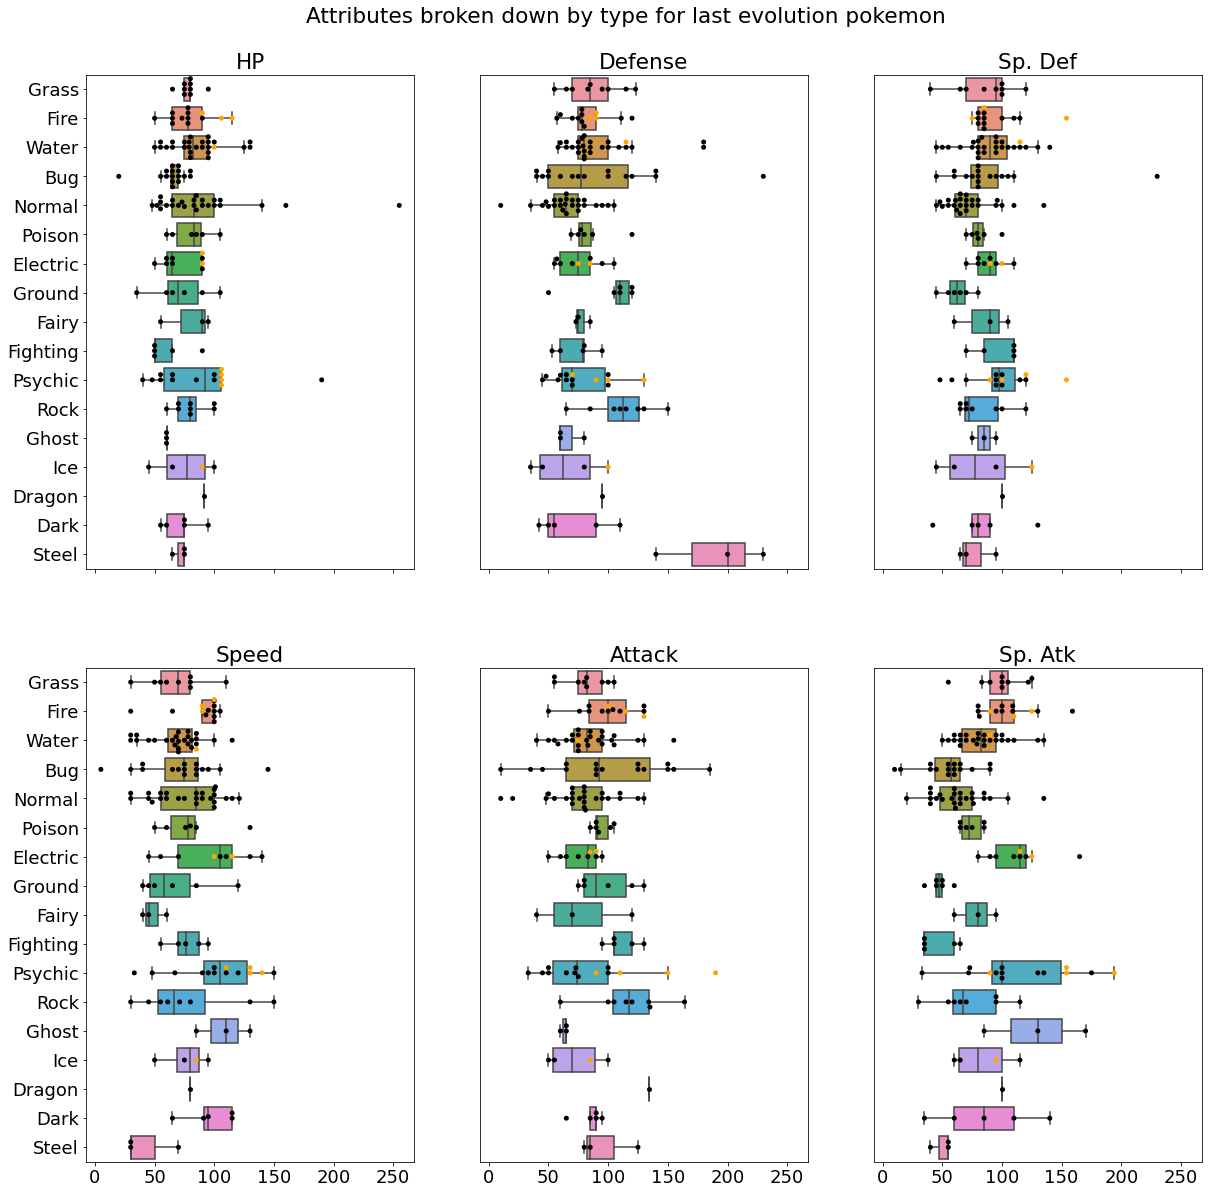

In [138]:
(f, axes) = attr_per_type(my_evolved_pokemon, 'Type 1', 'Legendary')
_ = f.suptitle('Attributes broken down by type for last evolution pokemon', va='center', y=0.92)

Estos son los Pokémon reales que podrían usarse en una batalla de Pokémon, ya que tener una evolución significa que tus estadísticas aumentarán y tendrás acceso a un grupo de movimientos más amplio. Ahora, sería interesante plotear las frecuencias de los Tipos 1 y 2 que tenemos en este data set.

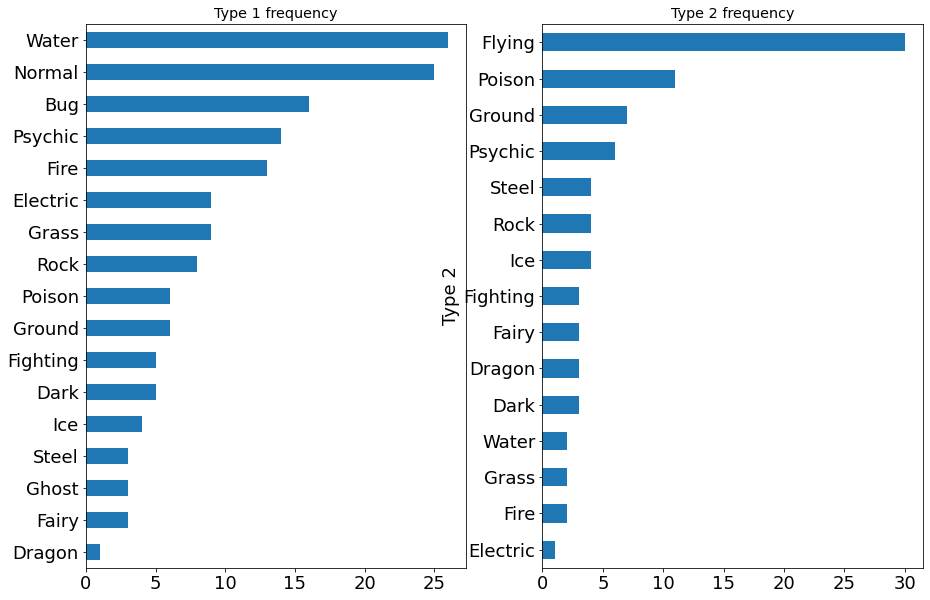

In [139]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10))
mpl.rcParams["font.size"] = 12

ax1 = my_evolved_pokemon.groupby('Type 1').size().sort_values().plot(kind='barh', ax=ax1)
start, end = ax1.get_xlim()
ax1.xaxis.set_ticks(np.arange(start, end, 5))
ax1.axes.get_yaxis().get_label().set_visible(False)
_ = ax1.set_title('Type 1 frequency')

ax2 = my_evolved_pokemon.groupby('Type 2').size().sort_values().plot(kind='barh', ax=ax2)
start, end = ax1.get_xlim()
ax1.xaxis.set_ticks(np.arange(start, end, 5))
ax1.axes.get_yaxis().get_label().set_visible(False)
_ = ax2.set_title('Type 2 frequency')

Ahora, para fines didácticos realizaremos un heatmap haciendo un conteo de ambos, mostrando aquellas combinaciones de tipos

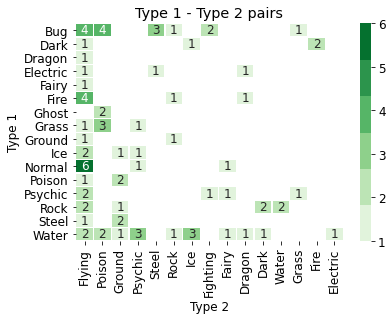

In [140]:
pivot_dat = my_evolved_pokemon.pivot_table(index='Type 1', 
                                           columns='Type 2', 
                                           aggfunc = 'size')
pivot_dat = pivot_dat[pivot_dat.sum().sort_values(ascending = False).index] #Reordering
ax2 = sns.heatmap(pivot_dat, 
                  annot=True, 
                  cmap=sns.color_palette("Greens"), 
                  cbar=True, 
                  linewidths=0.3)
_ = ax2.set_title('Type 1 - Type 2 pairs')
fig.tight_layout()

In [142]:
my_evolved_pokemon['New type'] = my_evolved_pokemon['Type 1']
my_evolved_pokemon['Dual type'] = ~pd.isnull(my_pokemon['Type 2'])
dual_evolved_pokemon = my_evolved_pokemon.append(my_evolved_pokemon[my_evolved_pokemon['Dual type']==True], ignore_index=True)

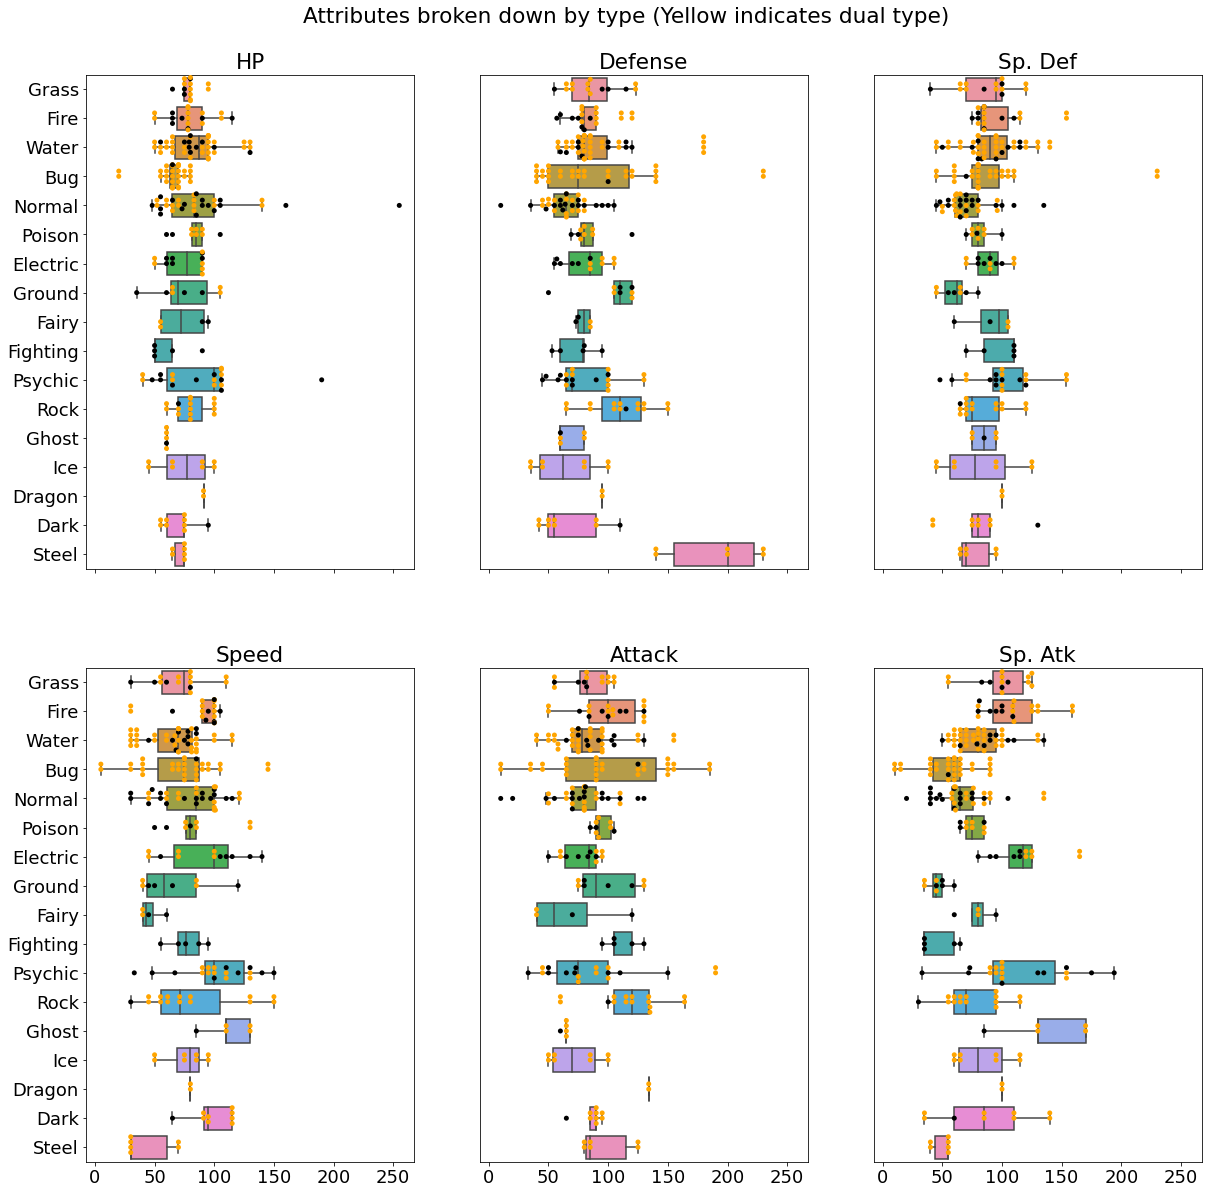

In [143]:
(f, axes) = attr_per_type(dual_evolved_pokemon, 'New type', 'Dual type')
_ = f.suptitle("Attributes broken down by type (Yellow indicates dual type)", va='center', y=0.92)

Ahora, mostremos la distribución de los datos utilizando el método de displot


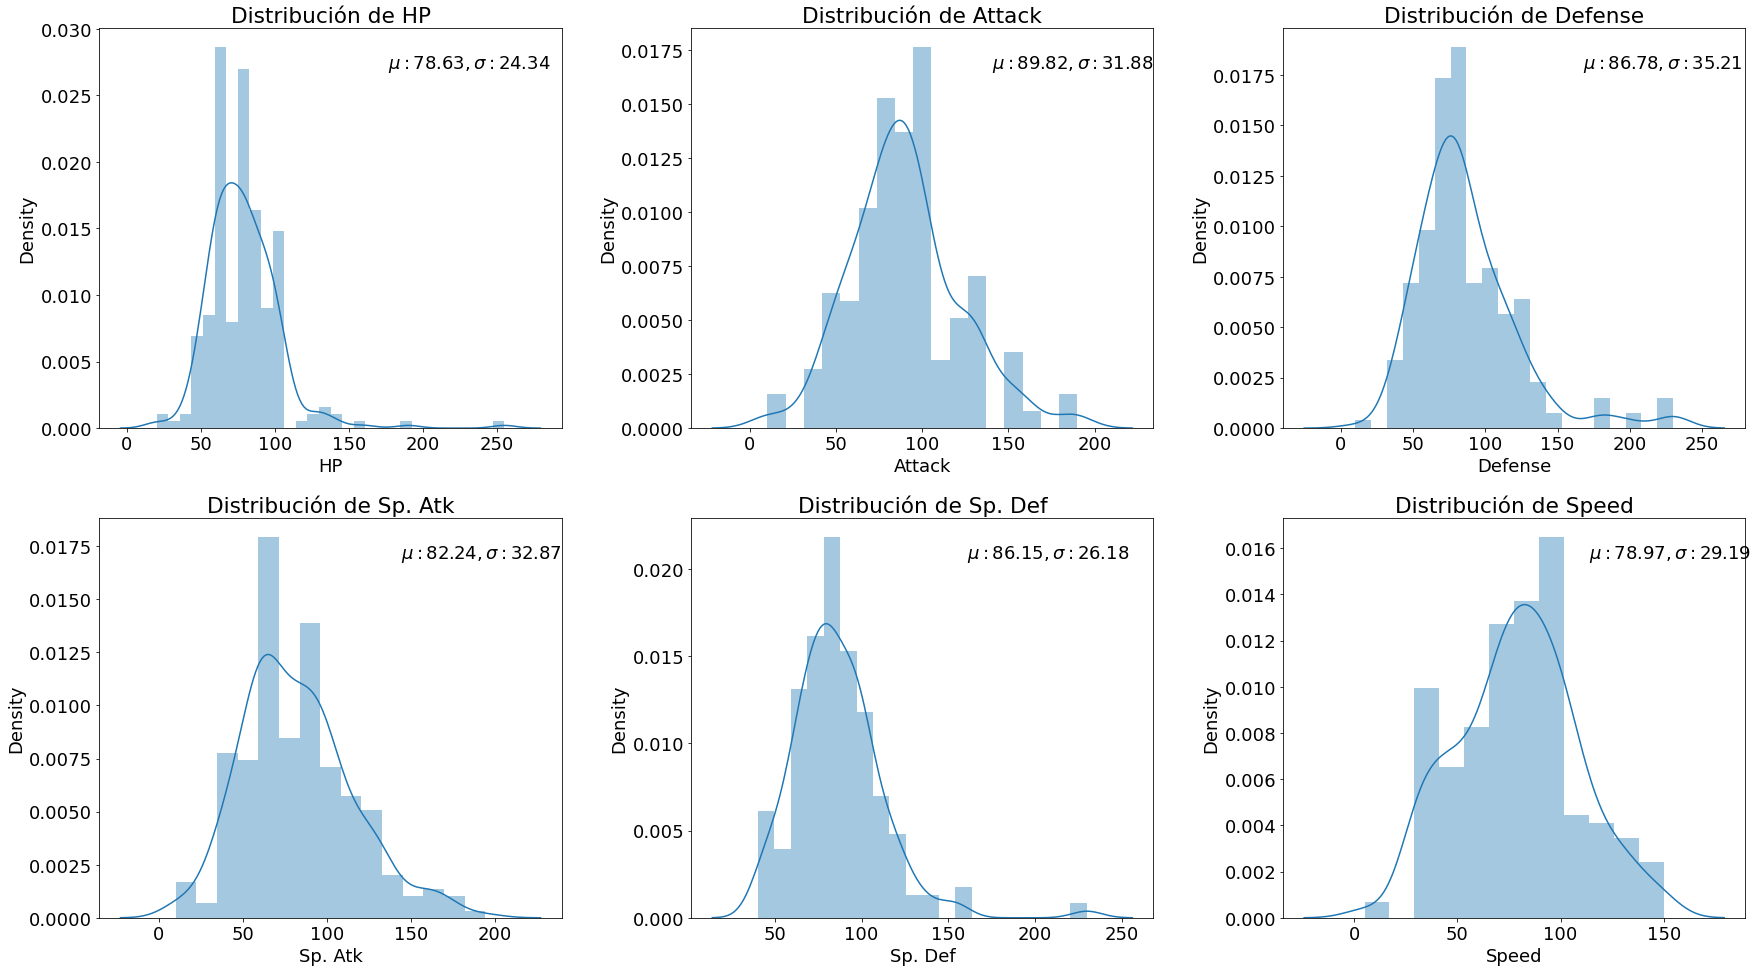

In [227]:
stats = dual_evolved_pokemon.loc[:, 'HP':'Speed']
plt.figure(figsize=(25, 20))

for ii, stat in enumerate(stats):
    title = "Distribución de {stat}".format(
        stat = stat
    )
    plt.subplot(3, 3, ii+1)
    plt.title(title)
    sns.distplot(dual_evolved_pokemon[stat])
    x = plt.gca().get_xlim()[1] * .6
    y = plt.gca().get_ylim()[1] * .9
    plt.text(x, y, '$\mu: {mu: .2f}, \sigma: {sigma: .2f}$'.format(mu = dual_evolved_pokemon[stat].mean(), sigma=dual_evolved_pokemon[stat].std()))
    
plt.tight_layout()
plt.show()

Hagan la comparativa de como se ven estos datos con respecto al conjunto total que generaron de 4 generaciones

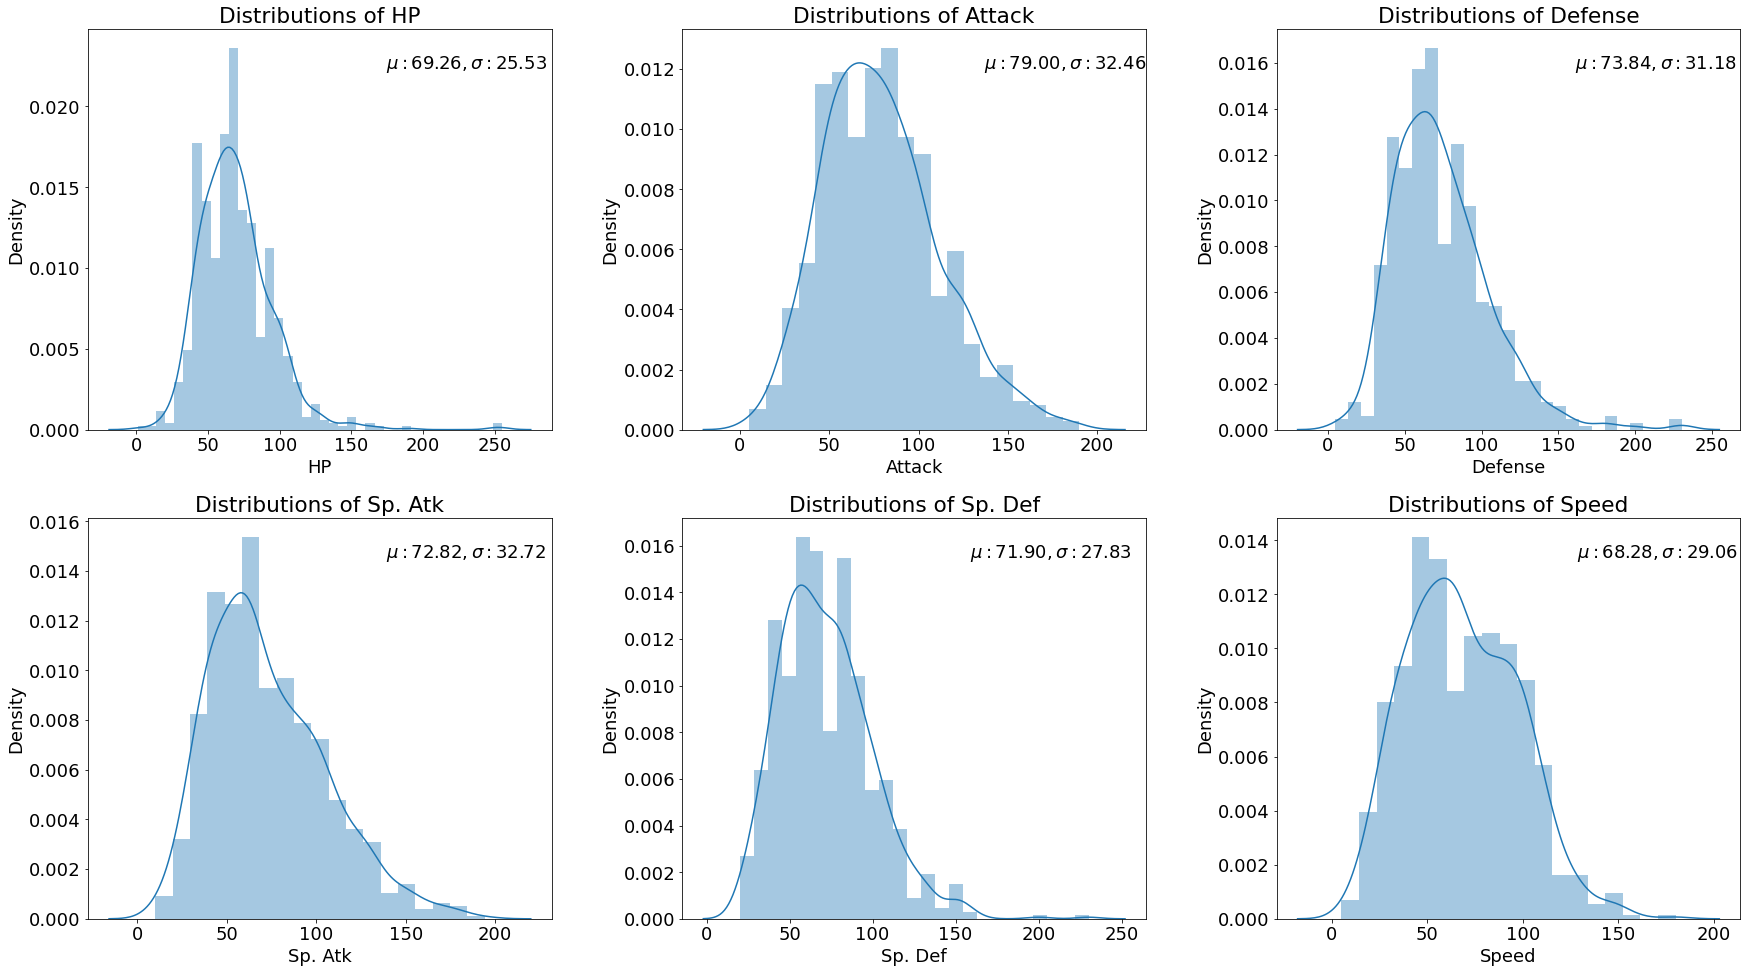

In [228]:
stats = pokemon.columns[5:11]
plt.figure(figsize=(25, 20))

for ii, stat in enumerate(stats):
    title = "Distributions of {stat}".format(
        stat = stat
    )
    plt.subplot(3, 3, ii+1)
    plt.title(title)
    sns.distplot(pokemon[stat])
    x = plt.gca().get_xlim()[1] * .6
    y = plt.gca().get_ylim()[1] * .9
    plt.text(x, y, '$\mu: {mu: .2f}, \sigma: {sigma: .2f}$'.format(mu = pokemon[stat].mean(), sigma=pokemon[stat].std()))
    
    
plt.tight_layout()
plt.show()

Asi como también la comparación entre tipos

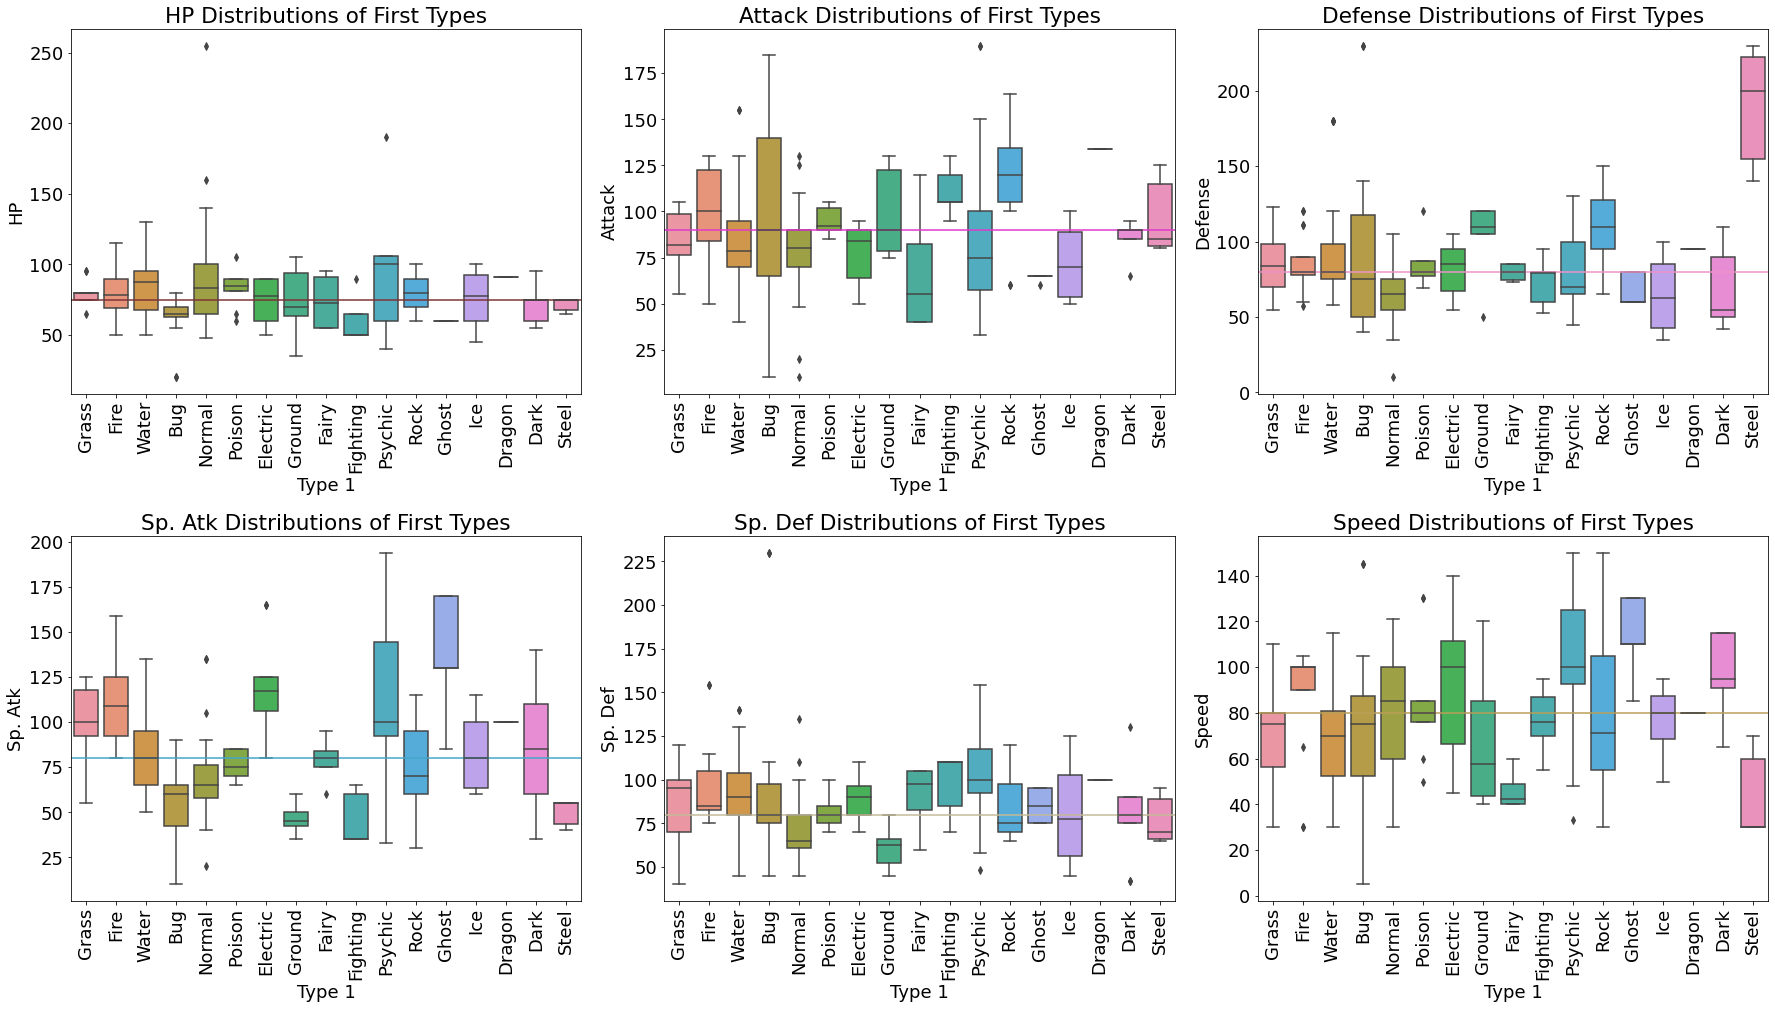

In [230]:
plt.figure(figsize=(25,20))

for ii, stat in enumerate(stats):
    title = "{stat} Distributions of First Types".format(
        stat = stat
    )
    plt.subplot(3, 3, ii+1)
    plt.title(title)
    plt.xticks(rotation=90)
    sns.boxplot(x='Type 1', y=stat, data = dual_evolved_pokemon)
    plt.axhline(dual_evolved_pokemon[stat].median(), color=np.random.rand(3))
    
plt.tight_layout()
plt.show()

Ahora para el conjunto que generaron de 4 generaciones

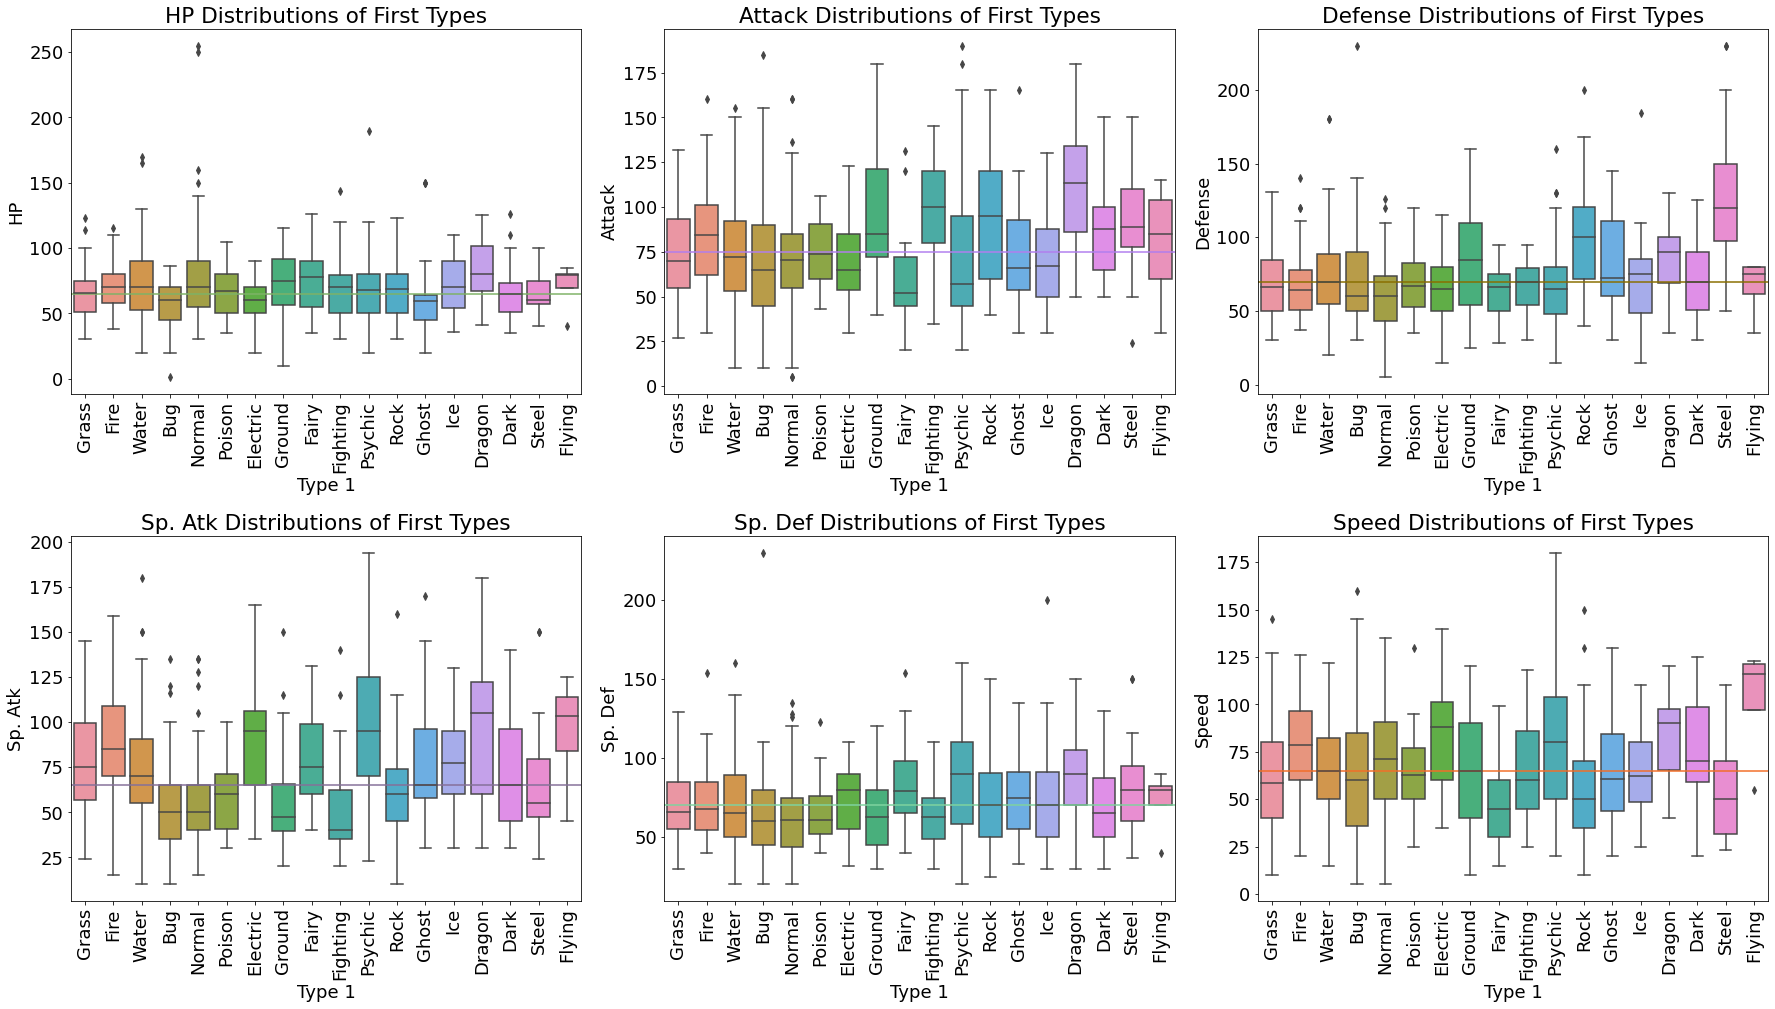

In [229]:
plt.figure(figsize=(25,20))

for ii, stat in enumerate(stats):
    title = "{stat} Distributions of First Types".format(
        stat = stat
    )
    plt.subplot(3, 3, ii+1)
    plt.title(title)
    plt.xticks(rotation=90)
    sns.boxplot(x='Type 1', y=stat, data = pokemon)
    plt.axhline(pokemon[stat].median(), color=np.random.rand(3))
    
plt.tight_layout()
plt.show()

# Modelos para saber si son o no legendarios

De primera instancia, sabemos que tenemos una columna que contiene la etiqueta booleana de True o False, para indicar si son o no legendarios

In [144]:
my_pokemon.Legendary.unique()

array([False,  True])

Vamos a realizar un descarte de columnas. 

Para X, solamente necesitaremos las columnas de características junto con su valor total (deberán ser 7 columnas)

Para Y, necesitamos la columna de legendarios ya que será nuestro objetivo.

In [182]:
X = my_pokemon.drop(columns =['#','Name', 'Type 1', 'Type 2', 'Generation', 'Legendary', 'Has_evol', 'Last_evol'])
y = my_pokemon['Legendary']

Por primera ocasión, estaremos utilizando la librería de sklearn para auxiliarnos en hacer el split de datos

In [183]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y) # 80% y 20%

Estaremos utilizando por primera vez, algunos modelos como son la regresión logística, las máquinas de soporte vectorial, árboles de decisión y bosque aleatorio

In [184]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier as DT
from sklearn.ensemble import RandomForestClassifier as RF

alg1 = LogisticRegression()
alg2 = SVC(kernel = 'rbf') #lineal , polinomial, radial basis fuction (gaussiano)
alg3 = RF()
alg4 = DT()

Posteriormente, entrenaremos cada uno de los modelos.
Para obtener el valor del "Accuracy" (Exactitud), necesitamos comparar el valor original de ambos sets contra el valor predicho del algoritmo

In [185]:
from sklearn.metrics import accuracy_score
alg1.fit(X_train, y_train)

pd.DataFrame({"Accuracy on Train":[accuracy_score(y_train, alg1.predict(X_train))],
    "Accuracy on Test":[accuracy_score(y_test, alg1.predict(X_test))]})

,Accurancy on Train,Accurancy on Test
0,0.970588,0.941176


In [186]:
alg2.fit(X_train, y_train) #Training the model
pd.DataFrame({"Accuracy on Train":[accuracy_score(y_train, alg2.predict(X_train))],
    "Accuracy on Test":[accuracy_score(y_test, alg2.predict(X_test))]})


,Accurancy on Train,Accurancy on Test
0,0.965686,0.970588


In [187]:
alg3.fit(X_train, y_train) #Training the model
pd.DataFrame({"Accuracy on Train":[accuracy_score(y_train, alg3.predict(X_train))],
    "Accuracy on Test":[accuracy_score(y_test, alg3.predict(X_test))]})

,Accurancy on Train,Accurancy on Test
0,1.0,0.970588


In [188]:
alg4.fit(X_train, y_train) #Training the model
pd.DataFrame({"Accuracy on Train":[accuracy_score(y_train, alg4.predict(X_train))],
    "Accuracy on Test":[accuracy_score(y_test, alg4.predict(X_test))]})

,Accurancy on Train,Accurancy on Test
0,1.0,1.0


En este paso, queremos hacer un filtro del arreglo "dual_evolved_pokemon" de todos aquellos que contengan ahora la palabra "Mega"

In [280]:
a_test = dual_evolved_pokemon[dual_evolved_pokemon["Name"].str.contains("Mega")]
a_test

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,Has_evol,Last_evol,New type,Dual type
1,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False,False,False,Grass,True
3,6,CharizardMega Charizard X,Fire,Dragon,634,78,130,111,130,85,100,1,False,False,False,Fire,True
4,6,CharizardMega Charizard Y,Fire,Flying,634,78,104,78,159,115,100,1,False,False,False,Fire,True
6,9,BlastoiseMega Blastoise,Water,NaN,630,79,103,120,135,115,78,1,False,False,False,Water,False
9,15,BeedrillMega Beedrill,Bug,Poison,495,65,150,40,15,80,145,1,False,False,False,Bug,True
11,18,PidgeotMega Pidgeot,Normal,Flying,579,83,80,80,135,80,121,1,False,False,False,Normal,True
30,65,AlakazamMega Alakazam,Psychic,NaN,590,55,50,65,175,95,150,1,False,False,False,Psychic,False
36,80,SlowbroMega Slowbro,Water,Psychic,590,95,75,180,130,80,30,1,False,False,False,Water,True
44,94,GengarMega Gengar,Ghost,Poison,600,60,65,80,170,95,130,1,False,False,False,Ghost,True
57,115,KangaskhanMega Kangaskhan,Normal,NaN,590,105,125,100,60,100,100,1,False,False,False,Normal,False


Vamos a probar ahora nuestros modelos. Usaremos a estos ejemplos para observar si los modelos pueden realizar una buena predicción de si es o no un legendario (que no debería ser)

In [178]:
np.array([a_test.iloc[1,4:11]])

array([[634, 78, 130, 111, 130, 85, 100]], dtype=object)

In [192]:
alg1.predict(np.array([a_test.iloc[1,4:11]]))

array([ True])

In [193]:
alg2.predict(np.array([a_test.iloc[1,4:11]]))

array([False])

In [194]:
alg3.predict(np.array([a_test.iloc[1,4:11]]))

array([False])

In [195]:
alg4.predict(np.array([a_test.iloc[1,4:11]]))

array([False])

Prueben con otros 10 ejemplos!

### ¿Podrían tratar de dar una idea de porque en algunos casos los modelos se han equivocado?